# 02805 Social Graphs and Interactions
## Final Assignment

**Date:** Wednesday, December 11th, 2024

**Group Members:**  
- Member 1: Rasmus Ulrik Kristensen (s233787)
- Member 2: Phillip Ravn Boe Jensen (s233478)

**Notation**
- 🐍 is used for code explanation.
- 🧠 
---


## Imports

In this section, we import the required Python libraries. These include:
- **NetworkX** for graph construction and analysis.
- **Pandas** for data manipulation.
- **NLTK** and **Scikit-learn** for natural language processing.
- **Matplotlib** for data visualization.
                

## Imports

In [87]:
import os
import re
import math
import statistics
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import networkx as nx
from community import community_louvain
from fa2_modified import ForceAtlas2
import requests
from urllib.request import urlopen
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from PIL import Image
import pickle
import bz2file as bz2


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Helper functions

In [88]:
base_path = "../data/ml/small"

In [89]:
def save(title, data):
    with bz2.BZ2File(f"{os.path.join(base_path, title)}.pbz2", "w") as f:
        pickle.dump(data, f)

In [90]:
def load(title):
    with bz2.BZ2File(f"{os.path.join(base_path, title)}.pbz2", "r") as f:
        return pickle.load(f)

In [91]:
def get_csv(name):
    return pd.read_csv(os.path.join(base_path, name))


## Data Processing

### Dataset Overview
We are working with two primary datasets:
1. **MovieLens Dataset**: Contains user ratings, movie metadata, and genres.
2. **Wikipedia Plot Data**: Extracted movie plots to analyze sentiment and keywords.

Data processing includes:
- Loading the datasets.
- Cleaning and preprocessing data to remove irrelevant or inconsistent entries.
- Preparing the data for network and NLP analyses.
                
            

#### CSV

In [92]:
ratings_df = get_csv("ratings.csv")
movies_df = get_csv("movies.csv")

#### ml data helpers

In [93]:
def get_movie_ids():
   return movies_df['movieId'].values

In [ ]:
def get_user_rating_for_movie(user_id, movie_id):
    return ratings_df[(ratings_df['userId'] == user_id) & (ratings_df['movieId'] == movie_id)]['rating'].values[0]

In [95]:
def get_user_movies(user_id):
    user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
    return user_movies

In [96]:
def get_movie_title_from_id(movie_id):
    return movies_df[movies_df['movieId'] == movie_id]['title'].values[0]

In [97]:
def get_movies_for_genre(genre):
    genre_movies = movies_df[movies_df['genres'].str.contains(genre, case=False)]['movieId'].values
    return genre_movies

In [98]:
def get_user_movies_with_genre(user_id, genre):
    user_movies = get_user_movies(user_id)
    genre_movies = get_movies_for_genre(genre)
    return set(user_movies) & set(genre_movies)

In [99]:
def get_genres_for_movie(movie_id):
    return movies_df[movies_df['movieId'] == movie_id]['genres'].values[0].split("|")

#### ml genres

In [100]:
movies_df['genre_list'] = movies_df['genres'].apply(lambda x: x.split('|'))
movie_genres = movies_df[['movieId', 'genre_list']].set_index('movieId').to_dict()['genre_list']

In [101]:
movies_df['primary_genre'] = movies_df['genre_list'].apply(lambda x: x[0]) 
movie_to_genre = movies_df[['movieId', 'primary_genre']].set_index('movieId').to_dict()['primary_genre']


### Plots from wikipedia

In [102]:
def get_best_match_with_plot(movie_title):
    url = "https://en.wikipedia.org/w/api.php"
    
    search_params = {
        'action': 'query',
        'format': 'json',
        'list': 'search',
        'srsearch': movie_title,
        'srprop': '',  
    }

    search_response = requests.get(url, params=search_params)
    search_data = search_response.json()

    search_results = search_data['query']['search']
    if not search_results:
        return "No matching page found."

    for result in search_results:
        title = result['title']
        
        page_params = {
            'action': 'parse',
            'format': 'json',
            'page': title,
        }

        page_response = requests.get(url, params=page_params)
        page_data = page_response.json()

        if 'parse' in page_data and 'sections' in page_data['parse']:
            sections = page_data['parse']['sections']
            
            for section in sections:
                if section['line'].lower() == 'plot':
                    return f"https://en.wikipedia.org/wiki/{title.replace(' ', '_')}"
    
    print(f"No 'Plot' section found for '{movie_title}'")
    return None

In [103]:
def extract_plot_text(url):
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, "html.parser")
    
    plot_heading = soup.find('h2', id="Plot")
    if not plot_heading:
        print("Plot section not found.")
        return None

    current_element = plot_heading.find_next("p")
    plot_text = []

    while current_element and current_element.name != "div":
        if current_element.name == "p":
            plot_text.append(current_element.get_text(strip=True))
        current_element = current_element.find_next_sibling()

    if not plot_text:
        print("No plot text found.")
        return None

    return " ".join(plot_text)

In [104]:
def create_movie_id_plot_dict(movie_id_plot, movie_ids_to_skip, name, name_skip):
    movie_ids = get_movie_ids()
    movie_ids = [id for id in movie_ids if id not in movie_id_plot.keys() and id not in movie_ids_to_skip]
    idx = len(movie_id_plot)
    for movie_id in movie_ids:
        title = get_movie_title_from_id(movie_id)
        best_match_url = get_best_match_with_plot(title)
        added = False
        if best_match_url:
            plot_text = extract_plot_text(best_match_url)
            if plot_text:
                movie_id_plot[movie_id] = plot_text
                added = True

        if not added:
            movie_ids_to_skip.append(movie_id)
        
        print(f"Processed {idx} movies.")

        if idx % 100 == 0:
            save(name, movie_id_plot)
            save(name_skip, movie_ids_to_skip)
            print(f"Saved at {idx}")
        
        idx += 1
    return movie_id_plot, movie_ids_to_skip

In [105]:
movie_id_plot = {}
name = "movie_id_plot_dict"
name_skip = "movie_ids_to_skip"

movie_ids_to_skip = []

if os.path.exists(f"{os.path.join(base_path, f'{name_skip}.pbz2')}"):
    movie_ids_to_skip = load(name_skip)
    print(f"Loaded {len(movie_ids_to_skip)} movie ids to skip.")

if os.path.exists(f"{os.path.join(base_path, f'{name}.pbz2')}"):
    movie_id_plot = load(name)
    print(f"Loaded {len(movie_id_plot)} movie plots.")

movie_id_plot, movie_ids_to_skip = create_movie_id_plot_dict(movie_id_plot, movie_ids_to_skip, name, name_skip)
save(name, movie_id_plot)
save(name_skip, movie_ids_to_skip)

Loaded 726 movie ids to skip.
Loaded 9016 movie plots.


### Word happines dict

In [106]:
path = "../data/word_happines"
if not os.path.exists(f"{path}.pbz2"):
    url = "https://hedonometer.org/api/v1/words/?format=json&wordlist__title=labMT-en-v2"

    limit = 1000 
    offset = 0 

    word_happiness_dict = {}

    while True:
        response = requests.get(url, params={"limit": limit, "offset": offset})
        
        if response.status_code == 200:
            data = response.json()
            
            for entry in data["objects"]:
                word_happiness_dict[entry["word"]] = entry["happs"]
            
            if data["meta"]["next"] is None:
                break  
            
            offset += limit
        else:
            print(f"Failed to retrieve data. Status code: {response.status_code}")
            break

    with bz2.BZ2File(f"{path}.pbz2", "w") as f:
        pickle.dump(data, f)
else:
    with bz2.BZ2File(f"{path}.pbz2", "r") as f:
        word_happiness_dict = pickle.load(f)

## Data cleaning

In [107]:
movies_df = movies_df[movies_df['movieId'].isin(movie_id_plot.keys())]

In [108]:
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']

In [109]:
movies_df = movies_df[movies_df['movieId'].isin(ratings_df['movieId'])]

In [110]:
ratings_df = ratings_df[ratings_df['movieId'].isin(movies_df['movieId'])]


## Graph Construction and Analysis

### Network Construction
We construct a bipartite graph where:
- **Nodes** represent users and movies.
- **Edges** represent user ratings for movies, with weights based on normalized scores.

### Key Metrics
- **Number of Nodes and Edges**: Provides a basic understanding of the graph size.
- **Degree Distribution**: Helps analyze the connectivity of nodes (users and movies).

### Community Detection
We use the **Louvain algorithm** to detect communities within the network. Communities group movies and users based on their interaction patterns, providing insights into shared preferences and genre alignments.
                

### Construction

In [111]:
ratings_df['rating'] = ratings_df['rating']/10

In [112]:
G = nx.Graph()

user_nodes = ratings_df['userId'].unique()
movie_nodes = movies_df['movieId'].unique()

G.add_nodes_from(movie_nodes, bipartite=0)
G.add_nodes_from(user_nodes, bipartite=1)

edges = ratings_df[['userId', 'movieId', 'rating']].values

G.add_weighted_edges_from(edges)

In [113]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 9084
Number of edges: 98290


### Lovuain partition

In [114]:
partition = community_louvain.best_partition(G)

### Louvain modularity 

In [115]:
modularity = community_louvain.modularity(partition, G)
print(f"Louvain Modularity: {modularity}")

Louvain Modularity: 0.2582701656265562


### Visualization

#### Forceatlas2 setup

In [116]:
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False, 
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=True,
    gravity=1.0,
    verbose=False
)

#### Forceatlas2 positions

In [117]:
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=1000)

#### Actual visualization

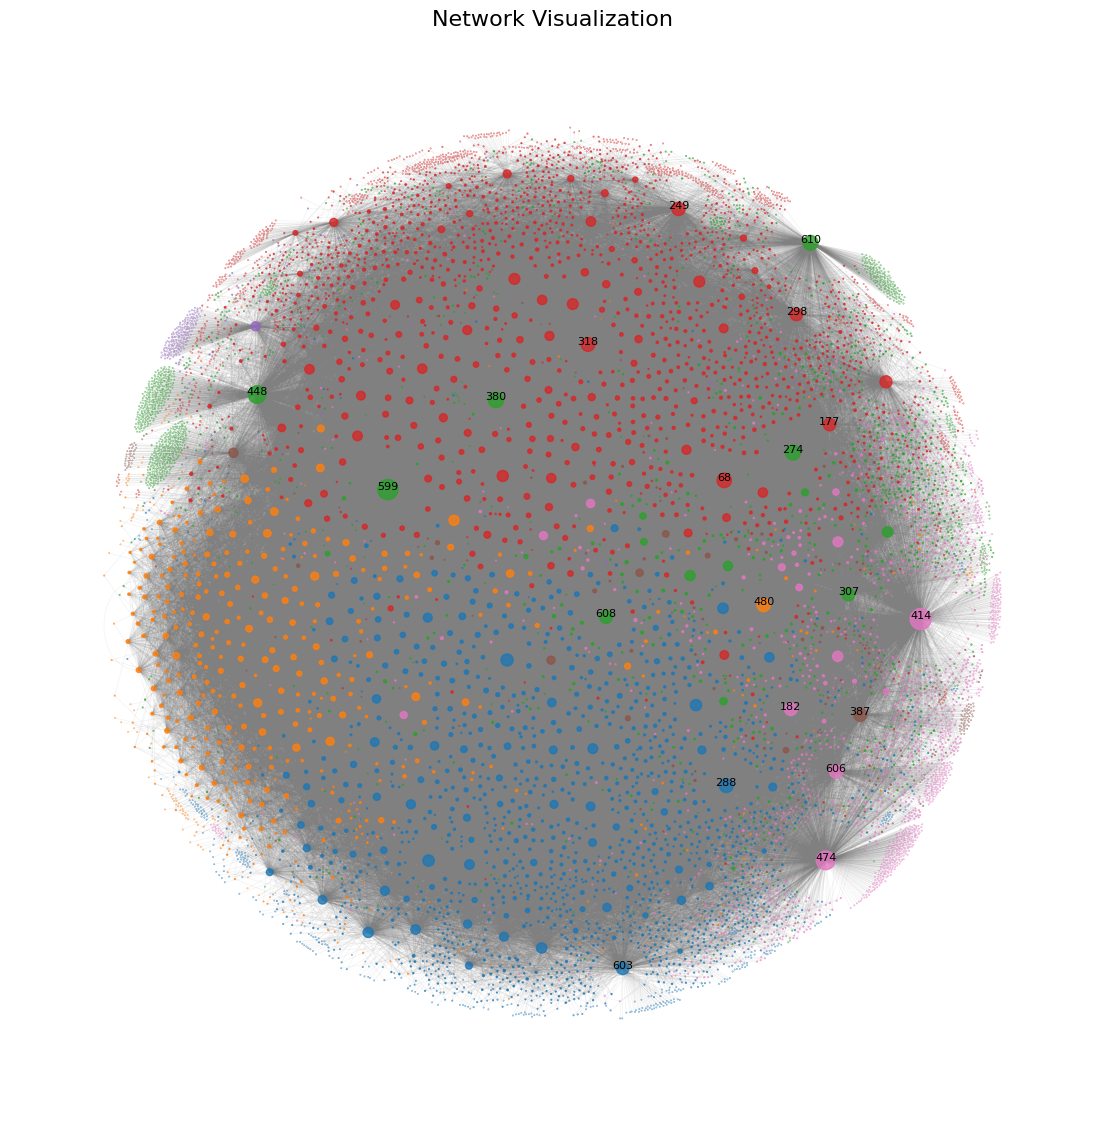

In [118]:
degree_centrality = nx.degree_centrality(G)
node_sizes = [v * 800 for v in degree_centrality.values()] 

partition_counts = Counter(partition.values())
most_common_partitions = partition_counts.most_common(10)
common_partitions_ids = set(community[0] for community in most_common_partitions)

colors = list(mcolors.TABLEAU_COLORS.keys())
partitions_colors = {partition_id: colors[i % len(colors)] for i, partition_id in enumerate(common_partitions_ids)}

node_colors = [
    partitions_colors[partition[node]] if partition[node] in partitions_colors else 'lightgray'
    for node in G.nodes
]


plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(G, positions, node_size=node_sizes, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, positions, edge_color="gray", alpha=0.1, width=0.5)

high_degree_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
for node, _ in high_degree_nodes:
    x, y = positions[node]
    plt.text(x, y, str(node), fontsize=8, ha='center', color='black')

plt.title("Network Visualization", fontsize=16)
plt.axis("off")
plt.show()


### Genre community modularity

In [123]:
for node in G.nodes():
    if node in movie_to_genre:
        G.nodes[node]['community'] = movie_to_genre[node]
    else:
        G.nodes[node]['community'] = None 


In [124]:
genre_partition = {}
for node, data in G.nodes(data=True):
    community = data.get('community')
    if community:
        genre_partition.setdefault(community, []).append(node)

genre_communities = [set(nodes) for nodes in genre_partition.values()]

In [125]:
M = 0
L = G.number_of_edges()

for nodes in genre_communities:
    Lc = G.subgraph(nodes).number_of_edges()
    Kc = sum([x for _, x in G.subgraph(nodes).degree(nodes)])
    M += ((Lc/L)-((Kc/(2*L))**2))

print(f"Genre community modularity: {M}")

Genre community modularity: 0.160818912136987


## User id to genres with movie ids to title and rating

In [126]:
def create_user_id_genre_movies_dict(G):
    dict = {}
    for node in G.nodes():
        user_id = node
        genre_movies = {}
        for movie_id in get_user_movies(user_id):
            genres = get_genres_for_movie(movie_id)
            for genre in genres:
                if genre not in genre_movies:
                    genre_movies[genre] = {}
                genre_movies[genre][movie_id] = (get_movie_title_from_id(movie_id), get_user_rating_for_movie(user_id, movie_id))
        dict[user_id] = genre_movies
    return dict

In [127]:
# user_id : { genre : { movie_id : (movie_title, rating) } }
user_genre_movies_name = "user_genre_movies"
if not os.path.exists(f"{os.path.join(base_path, f'{user_genre_movies_name}.pbz2')}"):
    user_genre_movies = create_user_id_genre_movies_dict(G)
    save("user_genre_movies", user_genre_movies)
else:
    user_genre_movies = load(user_genre_movies_name)

## Genre ratings

In [175]:
genre_ratings = defaultdict(list)
genre_stats = {}

for user_id, genres in user_genre_movies.items():
    for genre, movies in genres.items():
        for movie_id, (title, rating) in movies.items():
            genre_ratings[genre].append(rating)

for genre, ratings_df in genre_ratings.items():
    if len(ratings_df) > 0:
        sorted_ratings = sorted(ratings_df)
        genre_stats[genre] = {
            'mean': statistics.mean(ratings_df),
            'median': statistics.median(ratings_df),
            '25%': sorted_ratings[len(sorted_ratings) // 4], 
            '75%': sorted_ratings[(len(sorted_ratings) * 3) // 4],
            'count': len(ratings_df)
        }

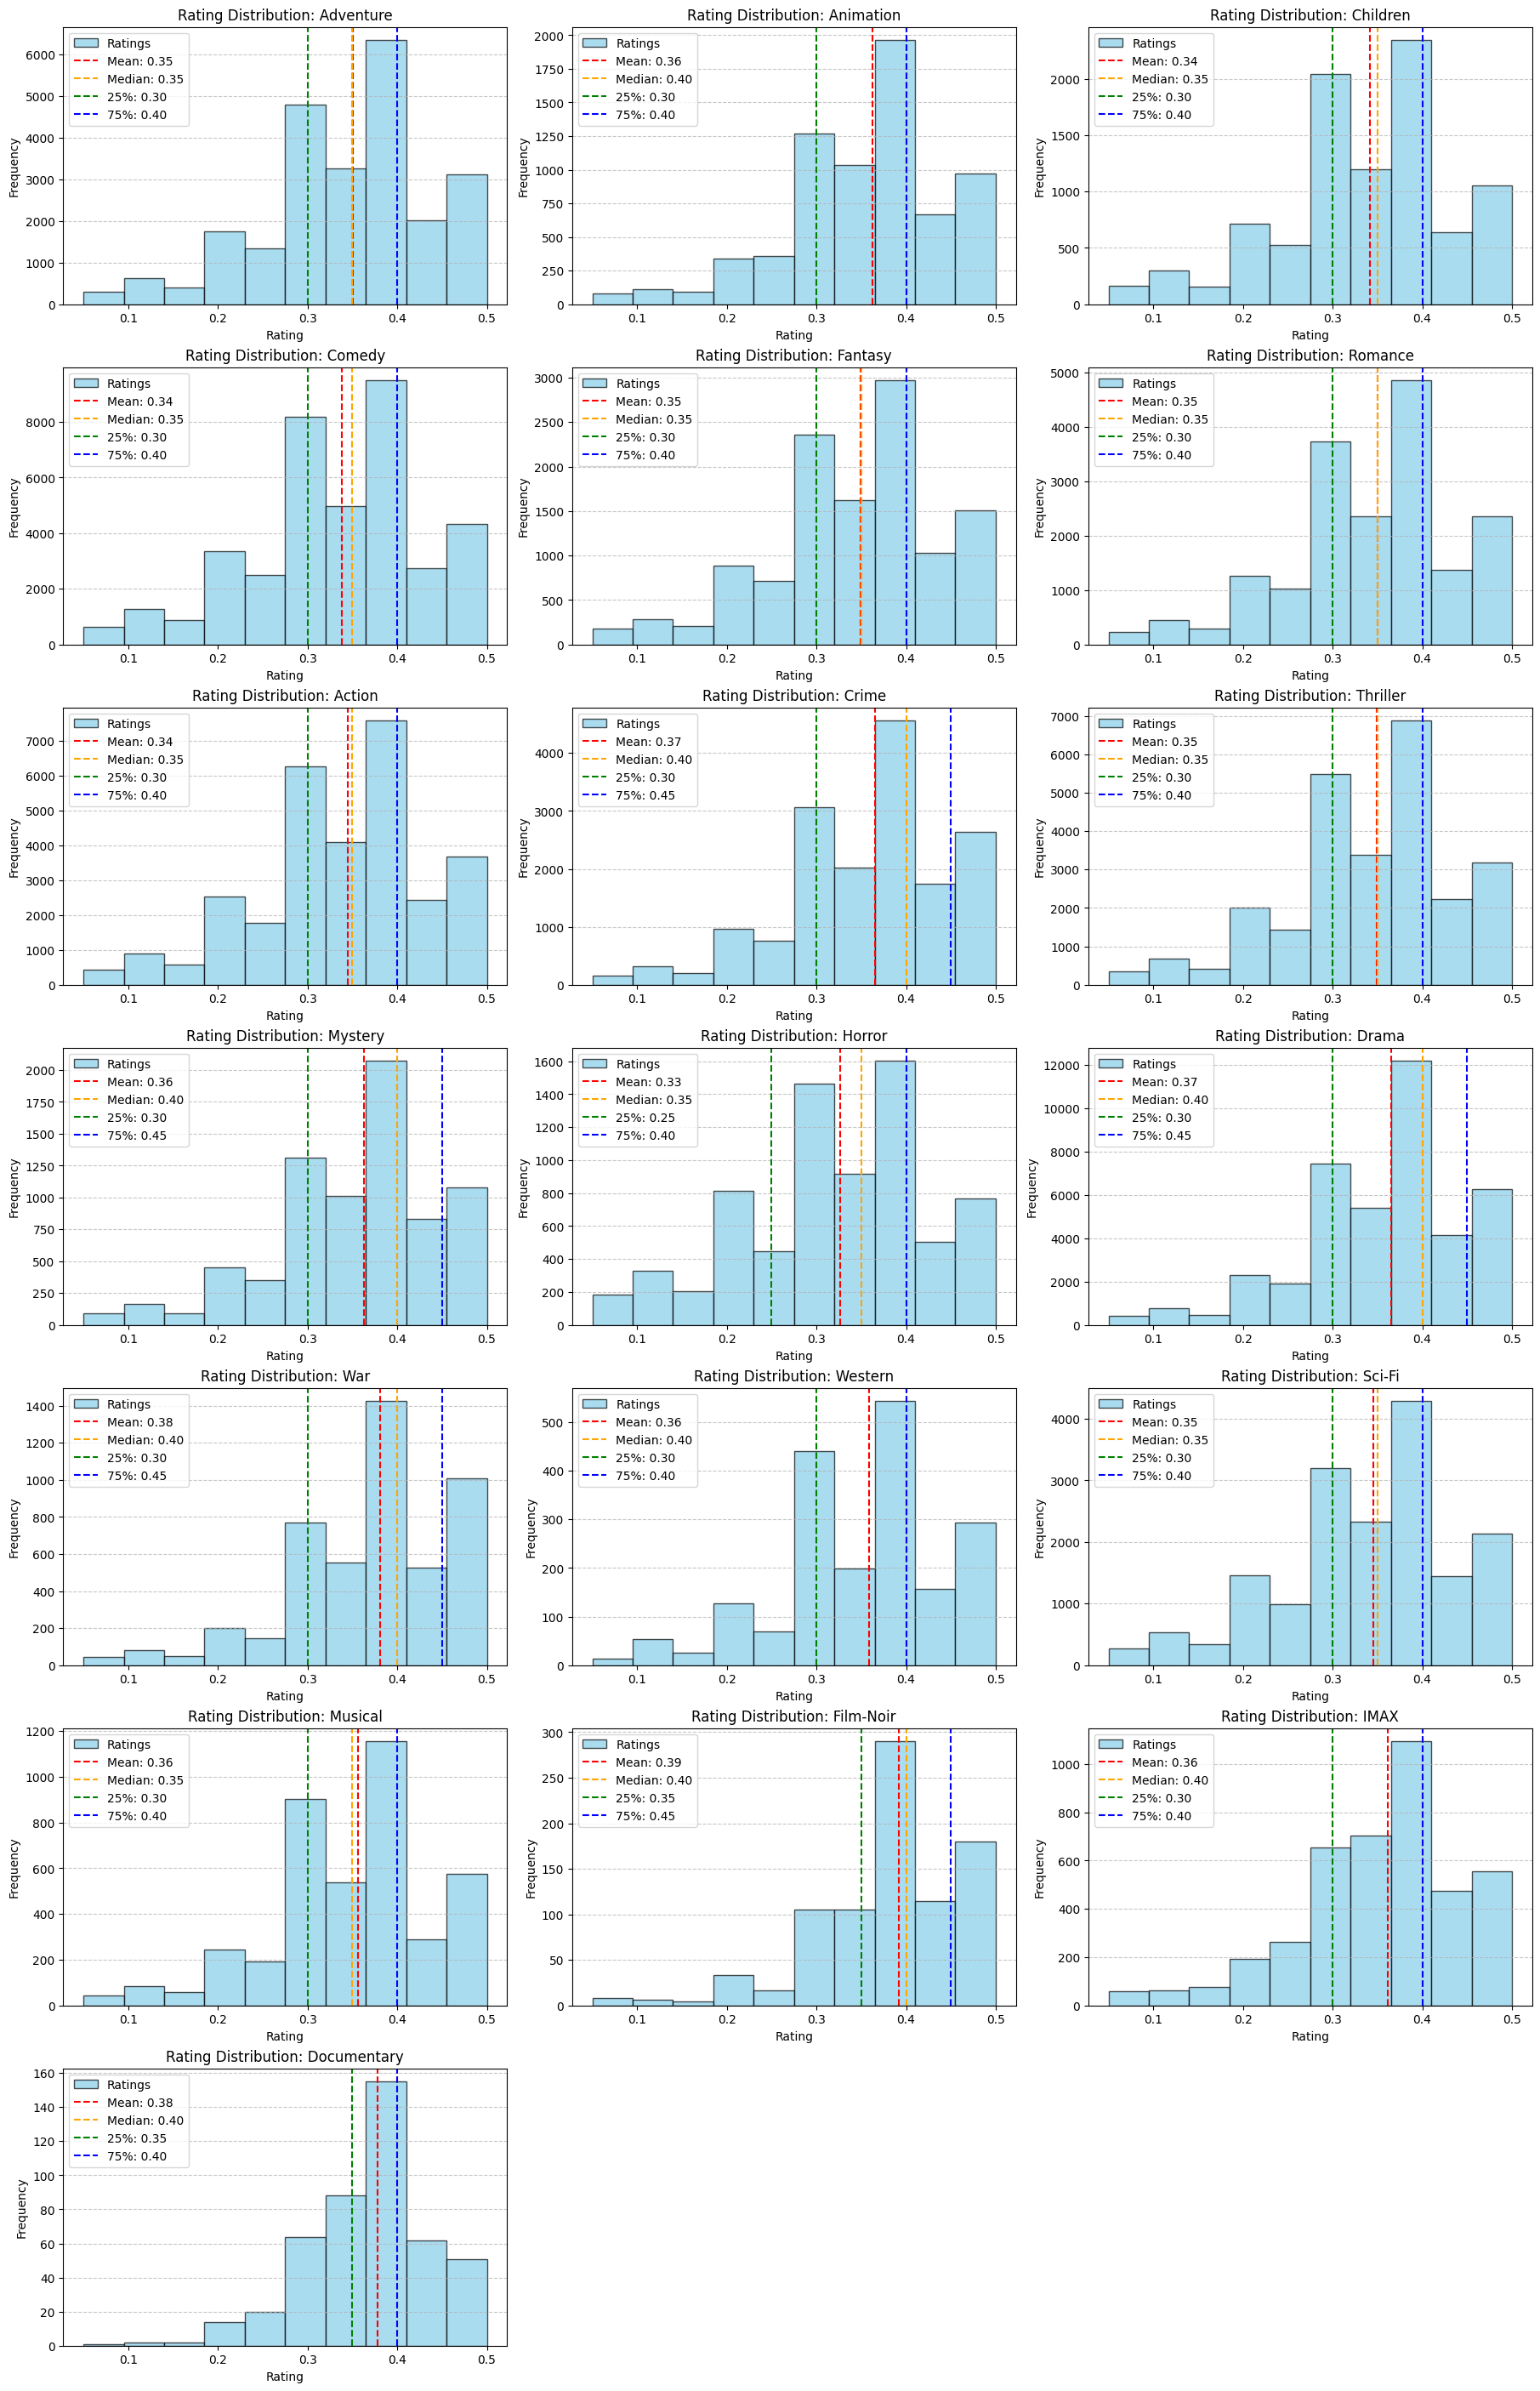

In [176]:
num_genres = len(genre_ratings)
num_rows = (num_genres + 2) // 3  

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 4 * num_rows), constrained_layout=True)
axes = axes.flatten()  

for idx, (genre, ratings_df) in enumerate(genre_ratings.items()):
    if len(ratings_df) > 0:
        stats_for_genre = genre_stats[genre]
        
        ax = axes[idx]  

        ax.hist(ratings_df, bins=10, color='skyblue', edgecolor='black', alpha=0.7, label='Ratings')
        ax.axvline(stats_for_genre['mean'], color='red', linestyle='--', label=f"Mean: {stats_for_genre['mean']:.2f}")
        ax.axvline(stats_for_genre['median'], color='orange', linestyle='--', label=f"Median: {stats_for_genre['median']:.2f}")
        ax.axvline(stats_for_genre['25%'], color='green', linestyle='--', label=f"25%: {stats_for_genre['25%']:.2f}")
        ax.axvline(stats_for_genre['75%'], color='blue', linestyle='--', label=f"75%: {stats_for_genre['75%']:.2f}")
        
        ax.set_title(f"Rating Distribution: {genre}")
        ax.set_xlabel("Rating")
        ax.set_ylabel("Frequency")
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(len(genre_ratings), len(axes)):
    fig.delaxes(axes[i])  

plt.show()

## User genre ratings

In [130]:
user_genre_avg_ratings = {}

for user_id, genres in user_genre_movies.items():
    user_genre_avg_ratings[user_id] = {}
    for genre, movies in genres.items():
        ratings_df = list([rating for _, (_, rating) in movies.items()])
        if ratings_df: 
            user_genre_avg_ratings[user_id][genre] = {
                'mean': np.mean(ratings_df),
                'median': np.median(ratings_df),
                'count': len(ratings_df)
            }

In [131]:
user_genre_ratings = defaultdict(lambda: defaultdict(list))

for user_id, genres in user_genre_movies.items():
    for genre, movies in genres.items():
        for _, (_, rating) in movies.items():
            user_genre_ratings[user_id][genre].append(rating)

## User genre bias

In [132]:
user_genre_bias = {}

for user_id, genres in user_genre_avg_ratings.items():
    genre_means = {genre: stats['mean'] for genre, stats in genres.items() if 'mean' in stats}

    if genre_means:
        max_genre = max(genre_means, key=genre_means.get) 
        min_genre = min(genre_means, key=genre_means.get) 
        
        overall_mean = statistics.mean(genre_means.values())

        max_genre_rating = genre_means[max_genre] 
        min_genre_rating = genre_means[min_genre] 
        
        genre_mean_diffs = {}
        for genre, ratings_df in user_genre_ratings[user_id].items():
            if len(ratings_df) > 1: 
                genre_mean_diffs[genre] = max(ratings_df) - min(ratings_df)
            else:
                genre_mean_diffs[genre] = 0  

        user_genre_bias[user_id] = {
            'highest_rated_genre': max_genre,
            'highest_rated_genre_rating': max_genre_rating,
            'lowest_rated_genre': min_genre,
            'lowest_rated_genre_rating': min_genre_rating,
            'mean_difference': max_genre_rating - min_genre_rating,
            'average_rating': overall_mean,
            'genre_mean_differences': genre_mean_diffs
        }


In [133]:
preferred_genres = Counter(bias['highest_rated_genre'] for bias in user_genre_bias.values())
least_preferred_genres = Counter(bias['lowest_rated_genre'] for bias in user_genre_bias.values())

print("Most Preferred Genres:")
print(preferred_genres.most_common())

print("\nLeast Preferred Genres:")
print(least_preferred_genres.most_common())


Most Preferred Genres:
[('War', 103), ('IMAX', 70), ('Film-Noir', 66), ('Mystery', 58), ('Western', 54), ('Animation', 42), ('Crime', 37), ('Horror', 34), ('Musical', 30), ('Documentary', 29), ('Fantasy', 19), ('Romance', 16), ('Sci-Fi', 15), ('Children', 13), ('Drama', 7), ('Adventure', 6), ('Thriller', 5), ('Action', 4), ('Comedy', 2)]

Least Preferred Genres:
[('Horror', 107), ('Western', 53), ('Children', 48), ('Fantasy', 45), ('Musical', 43), ('Sci-Fi', 38), ('War', 34), ('Animation', 33), ('IMAX', 31), ('Romance', 27), ('Mystery', 27), ('Comedy', 26), ('Film-Noir', 23), ('Action', 19), ('Crime', 16), ('Documentary', 13), ('Thriller', 12), ('Adventure', 11), ('Drama', 4)]


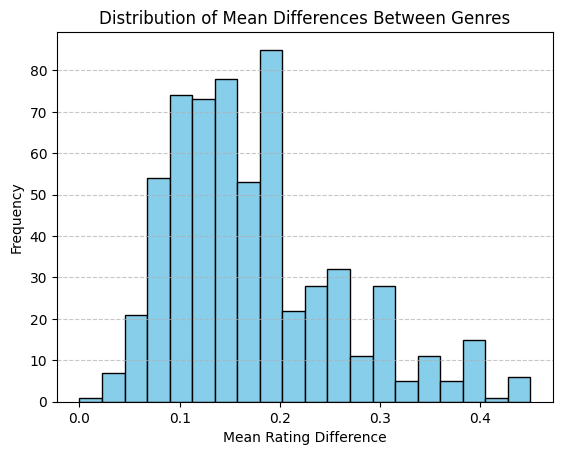

In [134]:
mean_differences = [bias['mean_difference'] for bias in user_genre_bias.values()]

plt.hist(mean_differences, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Mean Differences Between Genres')
plt.xlabel('Mean Rating Difference')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

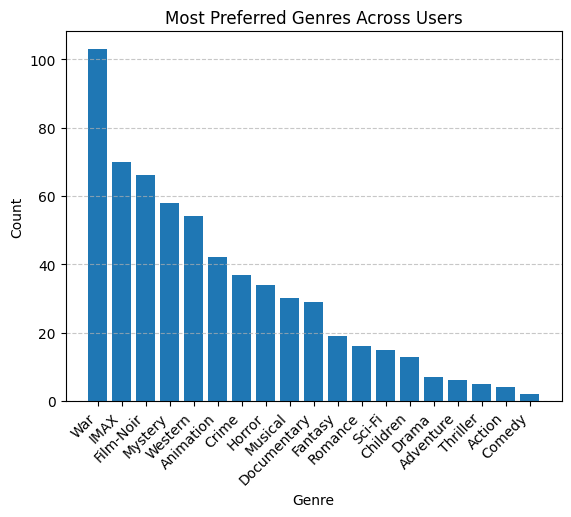

In [135]:
preferred_genres_sorted = preferred_genres.most_common()

genres = [genre for genre, _ in preferred_genres_sorted]
counts = [count for _, count in preferred_genres_sorted]

plt.bar(genres, counts)
plt.title('Most Preferred Genres Across Users')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [136]:
user_genre_avg_ratings = {}
user_movie_counts = {}  #

for user_id, genres in user_genre_movies.items():
    user_genre_avg_ratings[user_id] = {}
    user_movie_counts[user_id] = 0 
    
    for genre, movies in genres.items():
        ratings_df = [rating for _, (_, rating) in movies.items()]
        user_movie_counts[user_id] += len(ratings_df)  
        
        if ratings_df:
            user_genre_avg_ratings[user_id][genre] = statistics.mean(ratings_df)

In [137]:
genre_ratings_by_favorite = {} 
genre_ratings_all_users = {} 

for user_id, genres in user_genre_avg_ratings.items():
    for genre, avg_rating in genres.items():
        genre_ratings = [rating for _, (_, rating) in user_genre_movies[user_id].get(genre, {}).items()]
        
        if avg_rating == max(genres.values()):
            if genre not in genre_ratings_by_favorite:
                genre_ratings_by_favorite[genre] = []
            genre_ratings_by_favorite[genre].extend(genre_ratings)
        
        if genre not in genre_ratings_all_users:
            genre_ratings_all_users[genre] = []
        genre_ratings_all_users[genre].extend(genre_ratings)

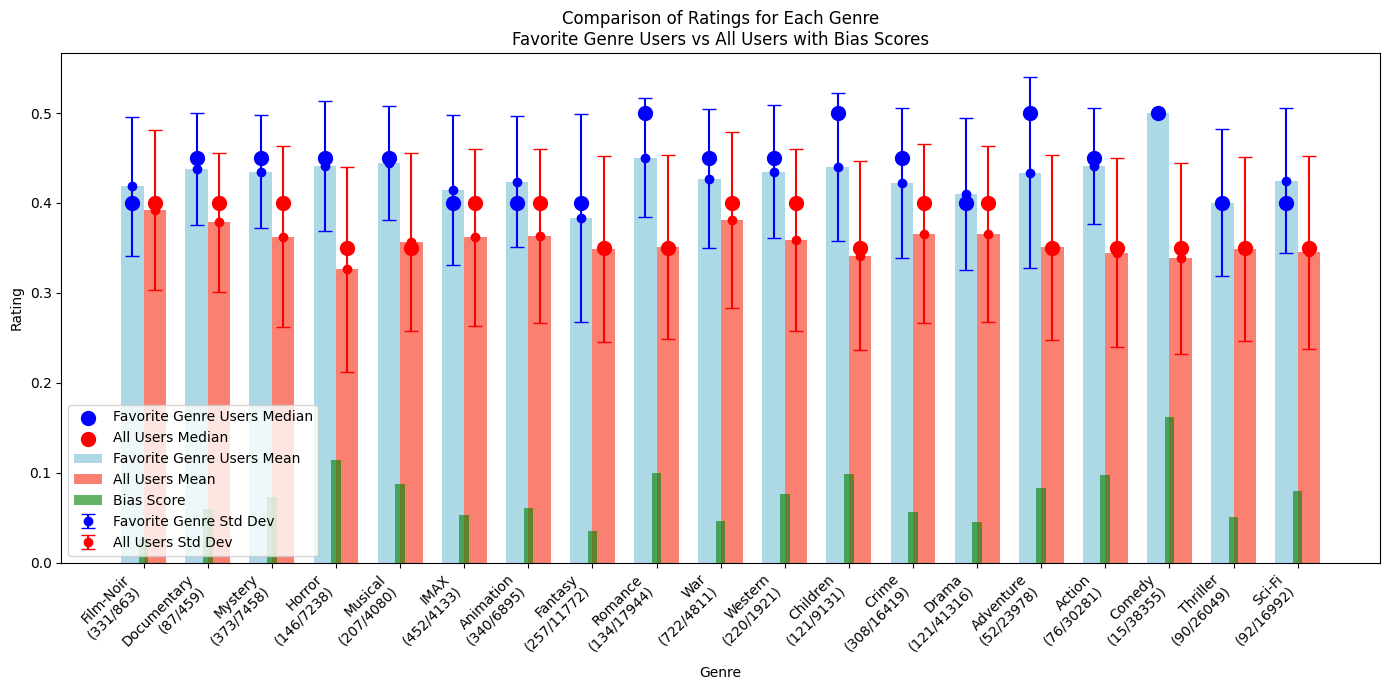

In [138]:
genre_labels = genre_ratings_by_favorite.keys()

favorite_ratings_means = []
favorite_ratings_medians = []
favorite_ratings_std = []
all_ratings_means = []
all_ratings_medians = []
all_ratings_std = []
bias_scores = []

for genre in genre_labels:
    favorite_ratings = genre_ratings_by_favorite[genre]
    all_ratings = genre_ratings_all_users[genre]

    favorite_ratings_mean = statistics.mean(favorite_ratings) if favorite_ratings else 0
    favorite_ratings_median = statistics.median(favorite_ratings) if favorite_ratings else 0
    favorite_ratings_std_dev = statistics.stdev(favorite_ratings) if len(favorite_ratings) > 1 else 0

    all_ratings_mean = statistics.mean(all_ratings) if all_ratings else 0
    all_ratings_median = statistics.median(all_ratings) if all_ratings else 0
    all_ratings_std_dev = statistics.stdev(all_ratings) if len(all_ratings) > 1 else 0

    bias_score = favorite_ratings_mean - all_ratings_mean

    favorite_ratings_means.append(favorite_ratings_mean)
    favorite_ratings_medians.append(favorite_ratings_median)
    favorite_ratings_std.append(favorite_ratings_std_dev)

    all_ratings_means.append(all_ratings_mean)
    all_ratings_medians.append(all_ratings_median)
    all_ratings_std.append(all_ratings_std_dev)

    bias_scores.append(bias_score)

x = np.arange(len(genre_labels)) 
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))

bar1 = ax.bar(x - width/2, favorite_ratings_means, width, label='Favorite Genre Users Mean', color='lightblue')
bar2 = ax.bar(x + width/2, all_ratings_means, width, label='All Users Mean', color='salmon')

ax.scatter(x - width/2, favorite_ratings_medians, color='blue', zorder=5, label='Favorite Genre Users Median', s=100)
ax.scatter(x + width/2, all_ratings_medians, color='red', zorder=5, label='All Users Median', s=100)

bias_bar = ax.bar(x, bias_scores, width=0.15, color='green', label='Bias Score', alpha=0.6)

ax.errorbar(x - width/2, favorite_ratings_means, yerr=favorite_ratings_std, fmt='o', color='blue', label='Favorite Genre Std Dev', capsize=5)
ax.errorbar(x + width/2, all_ratings_means, yerr=all_ratings_std, fmt='o', color='red', label='All Users Std Dev', capsize=5)

x_genre_labels = [f"{genre}\n({len(genre_ratings_by_favorite[genre])}/{len(genre_ratings_all_users[genre])})" for genre in genre_labels]

ax.set_xlabel('Genre')
ax.set_ylabel('Rating')
ax.set_title('Comparison of Ratings for Each Genre\nFavorite Genre Users vs All Users with Bias Scores')
ax.set_xticks(x)
ax.set_xticklabels(x_genre_labels, rotation=45, ha='right')

ax.legend()

plt.tight_layout()
plt.show()


## Sentiment

In [139]:
def get_tokens(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    return tokens

In [140]:
def calculate_sentiment(tokens):
    tokens = [token for token in tokens if token in word_happiness_dict]
    return sum(word_happiness_dict[token] for token in tokens) / len(tokens)

In [141]:
def get_movie_id_sentiment_dict(movie_id_plot_dict):
    movie_id_sentiment = {}
    for movie_id, plot in movie_id_plot_dict.items():
        tokens = get_tokens(plot)
        sentiment = calculate_sentiment(tokens)
        movie_id_sentiment[movie_id] = sentiment
    return movie_id_sentiment

In [142]:
name = "movie_id_sentiment_dict"
if not os.path.exists(f"{os.path.join(base_path, f'{name}.pbz2')}"):
     movie_id_sentiment = get_movie_id_sentiment_dict(movie_id_plot)
     save(name, movie_id_sentiment)

movie_id_sentiment = load(name)

In [143]:
sentiments = movie_id_sentiment.values()

In [144]:
mean = statistics.mean(sentiments)
median = statistics.median(sentiments)
std = statistics.stdev(sentiments)
quantiles = statistics.quantiles(sentiments, n=4)
print("Mean:", round(mean, 3))
print("Median:", round(median, 3))
print("Std. dev:", round(std, 3))
print("25th quantile", round(quantiles[0], 3))
print("75th quantile", round(quantiles[2], 3))

Mean: 5.335
Median: 5.332
Std. dev: 0.118
25th quantile 5.251
75th quantile 5.418


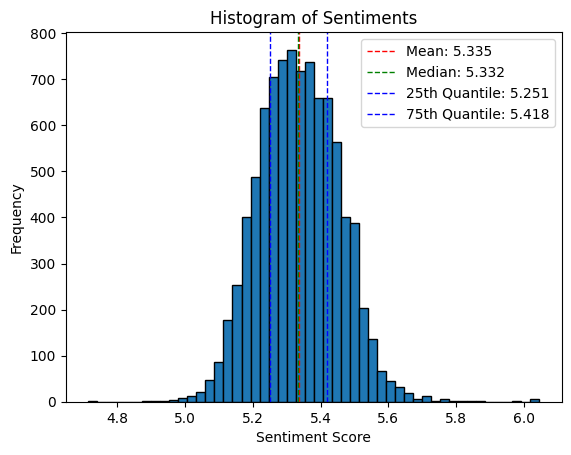

In [145]:
plt.hist(sentiments, bins=50, edgecolor='black')
plt.title('Histogram of Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.3f}')
plt.axvline(median, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median:.3f}')
plt.axvline(quantiles[0], color='b', linestyle='dashed', linewidth=1, label=f'25th Quantile: {quantiles[0]:.3f}')
plt.axvline(quantiles[2], color='b', linestyle='dashed', linewidth=1, label=f'75th Quantile: {quantiles[2]:.3f}')

plt.legend()
plt.show()

In [146]:
genre_sentiments = {}

for user_id, genres in user_genre_movies.items():
    for genre, movies in genres.items():
        if genre not in genre_sentiments:
            genre_sentiments[genre] = []
        for movie_id, (movie_title, _) in movies.items():
            if movie_id in movie_id_sentiment:
                genre_sentiments[genre].append(movie_id_sentiment[movie_id])

In [147]:
genre_sentiment_stats = {}

for genre, sentiments in genre_sentiments.items():
    if sentiments: 
        sorted_sentiments = sorted(sentiments)
        genre_sentiment_stats[genre] = {
            'mean': statistics.mean(sentiments),
            'median': statistics.median(sentiments),
            '25%': sorted_sentiments[len(sorted_sentiments) // 4],  
            '75%': sorted_sentiments[(len(sorted_sentiments) * 3) // 4], 
            'count': len(sentiments),
        }    

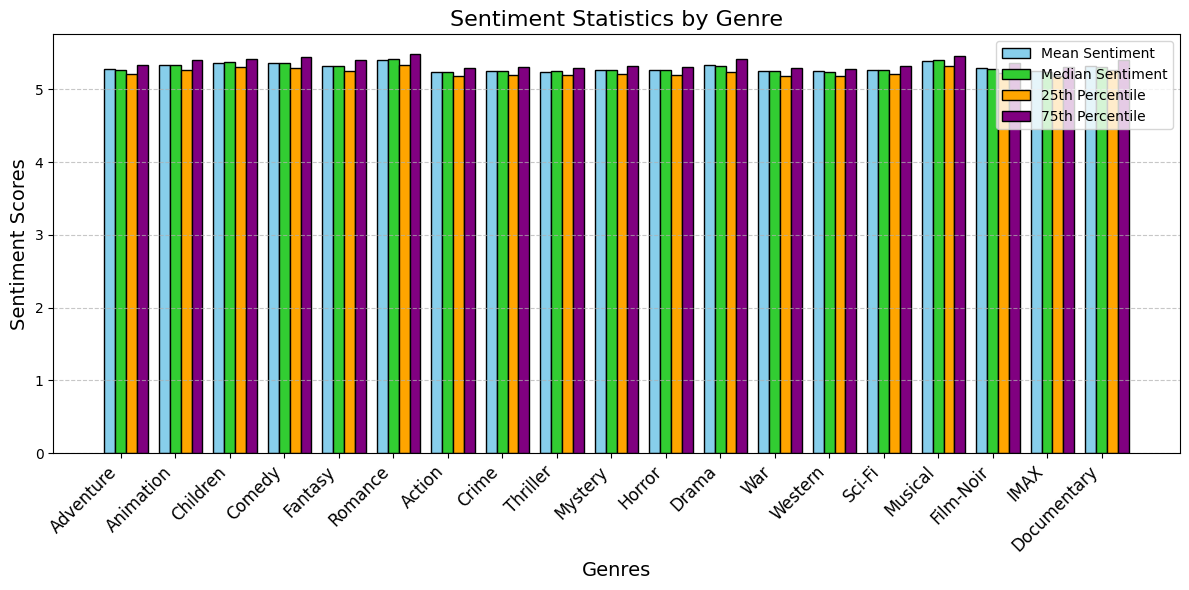

In [148]:
genres = list(genre_sentiment_stats.keys())
means = [stats['mean'] for stats in genre_sentiment_stats.values()]
medians = [stats['median'] for stats in genre_sentiment_stats.values()]
quantile_25 = [stats['25%'] for stats in genre_sentiment_stats.values()]
quantile_75 = [stats['75%'] for stats in genre_sentiment_stats.values()]

x = np.arange(len(genres))

bar_width = 0.2

plt.figure(figsize=(12, 6))

plt.bar(x - bar_width, means, width=bar_width, label='Mean Sentiment', color='skyblue', edgecolor='black')
plt.bar(x, medians, width=bar_width, label='Median Sentiment', color='limegreen', edgecolor='black')
plt.bar(x + bar_width, quantile_25, width=bar_width, label='25th Percentile', color='orange', edgecolor='black')
plt.bar(x + 2 * bar_width, quantile_75, width=bar_width, label='75th Percentile', color='purple', edgecolor='black')

plt.xlabel('Genres', fontsize=14)
plt.ylabel('Sentiment Scores', fontsize=14)
plt.title('Sentiment Statistics by Genre', fontsize=16)
plt.xticks(x, genres, rotation=45, ha='right', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

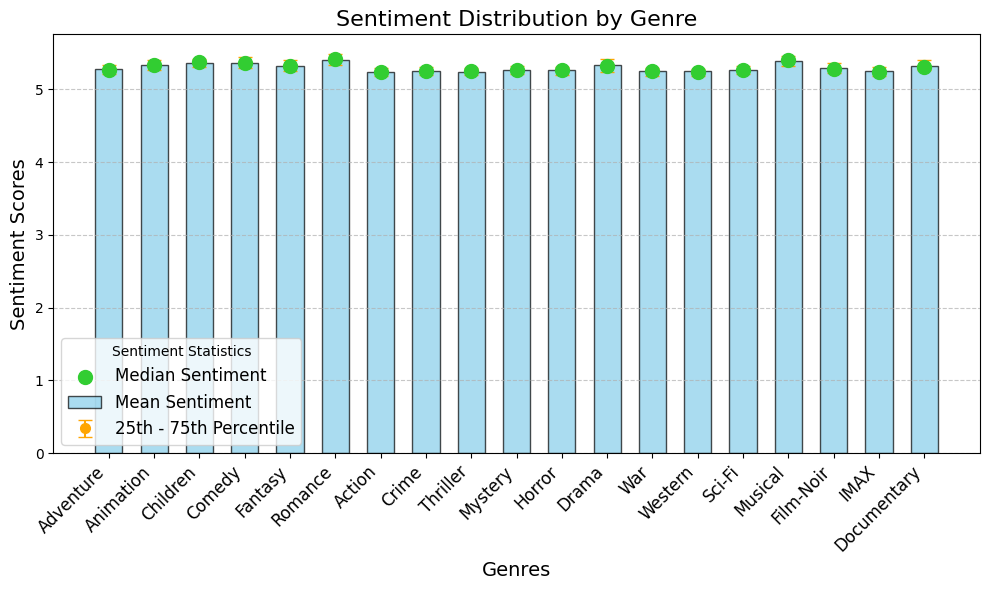

In [149]:
genre_sentiment_stats = {genre: stats for genre, stats in genre_sentiment_stats.items() if genre != '(no genres listed)'}
genres = list(genre_sentiment_stats.keys())
means = [stats['mean'] for stats in genre_sentiment_stats.values()]
medians = [stats['median'] for stats in genre_sentiment_stats.values()]
quantile_25 = [stats['25%'] for stats in genre_sentiment_stats.values()]
quantile_75 = [stats['75%'] for stats in genre_sentiment_stats.values()]

x = np.arange(len(genres))

plt.figure(figsize=(10, 6))

plt.bar(x, means, label='Mean Sentiment', color='skyblue', edgecolor='black', alpha=0.7, width=0.6)

plt.scatter(x, medians, color='limegreen', zorder=5, label='Median Sentiment', s=100, marker='o')

plt.errorbar(x, means, yerr=[np.array(means) - np.array(quantile_25), np.array(quantile_75) - np.array(means)],
             fmt='o', color='orange', label='25th - 75th Percentile', capsize=5, linestyle='None', markersize=7)

plt.xlabel('Genres', fontsize=14)
plt.ylabel('Sentiment Scores', fontsize=14)
plt.title('Sentiment Distribution by Genre', fontsize=16)
plt.xticks(x, genres, rotation=45, ha='right', fontsize=12)
plt.legend(title="Sentiment Statistics", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [150]:
genre_sentiments_sorted = sorted(genre_sentiment_stats.items(), key=lambda x: x[1]['mean'], reverse=True)
for genre, stats in genre_sentiments_sorted:
    print(f"Genre: {genre}", f"Mean Sentiment: {stats['mean']:.3f}")

Genre: Romance Mean Sentiment: 5.400
Genre: Musical Mean Sentiment: 5.390
Genre: Comedy Mean Sentiment: 5.365
Genre: Children Mean Sentiment: 5.363
Genre: Animation Mean Sentiment: 5.341
Genre: Drama Mean Sentiment: 5.329
Genre: Documentary Mean Sentiment: 5.327
Genre: Fantasy Mean Sentiment: 5.322
Genre: Film-Noir Mean Sentiment: 5.292
Genre: Adventure Mean Sentiment: 5.274
Genre: Sci-Fi Mean Sentiment: 5.268
Genre: Mystery Mean Sentiment: 5.266
Genre: Horror Mean Sentiment: 5.260
Genre: War Mean Sentiment: 5.254
Genre: Crime Mean Sentiment: 5.253
Genre: IMAX Mean Sentiment: 5.251
Genre: Western Mean Sentiment: 5.248
Genre: Thriller Mean Sentiment: 5.244
Genre: Action Mean Sentiment: 5.236



## TF-IDF and Word Clouds

### TF-IDF Analysis
**Term Frequency-Inverse Document Frequency (TF-IDF)** is used to extract important keywords from movie plots. It assigns higher scores to words that are frequent in a specific document (movie plot) but rare across all documents.

### Word Clouds
Visualize dominant themes and keywords for:
- Top-rated movies.
- Low-rated movies.
- Genre-specific plots.

This provides a deeper understanding of the textual attributes of movies and their alignment with user preferences.
                

### Movie based

In [151]:
def get_tokens_for_tfidf(text):
    tokens = word_tokenize(text)
    
    stop_words_set = set(stop_words)
    
    processed_tokens = []
    
    for word in tokens:
        word_lower = word.lower()
        if word_lower.isalpha() and word_lower not in stop_words_set:
            processed_tokens.append(lemmatizer.lemmatize(word_lower))
    
    return processed_tokens

In [152]:
def get_tf_dict(movie_id_plot_dict):
    tf_dict = {}
    for movie_id, plot in movie_id_plot_dict.items():
        tokens = get_tokens_for_tfidf(plot)
        tf_dict_inner = {}
        for token in tokens:
            if token not in tf_dict_inner:
                tf_dict_inner[token] = 1
            else:
                tf_dict_inner[token] += 1
        tf_dict[movie_id] = tf_dict_inner
    return tf_dict

In [153]:
def get_idf_dict(tf_dict):
    token_counts = {}

    for _, tf_dict_inner in tf_dict.items():
        unique_tokens = set(tf_dict_inner.keys())
        for token in unique_tokens:
            if token not in token_counts:
                token_counts[token] = 1
            else:
                token_counts[token] += 1

    idf_dict = {}
    for token, count in token_counts.items():
        idf_dict[token] = math.log(len(movie_id_plot) / count)
    
    return idf_dict

In [154]:
def movie_id_tfidf_dict(tf_dict, idf_dict):
    movie_id_tfidf = {}
    for movie_id, tf_dict_inner in tf_dict.items():
        tfidf_dict_inner = {}
        for token, count in tf_dict_inner.items():
            tfidf_dict_inner[token] = count * idf_dict[token]
        movie_id_tfidf[movie_id] = sorted(tfidf_dict_inner.items(), key=lambda x: x[1], reverse=True)
    return movie_id_tfidf

In [155]:
name = "movie_id_tfidf_dict"
if not os.path.exists(f"{os.path.join(base_path, f'{name}.pbz2')}"):
    tf_dict = get_tf_dict(movie_id_plot)
    idf_dict = get_idf_dict(tf_dict)
    movie_id_tfidf = movie_id_tfidf_dict(tf_dict, idf_dict)
    save(name, movie_id_tfidf)

movie_id_tfidf = load(name)

In [156]:
movie_id_to_ratings = {}

for user_id, genres in user_genre_movies.items():
    for genre, movies in genres.items():
        for movie_id, (_, rating) in movies.items():
            if movie_id not in movie_id_to_ratings:
                movie_id_to_ratings[movie_id] = []
            movie_id_to_ratings[movie_id].append(rating)


In [157]:
movie_id_to_avg_rating = {
    movie_id: sum(ratings) / len(ratings) for movie_id, ratings in movie_id_to_ratings.items()
}

In [158]:
movie_ratings_filtered = {
    movie_id: ratings
    for movie_id, ratings in movie_id_to_ratings.items()
    if len(ratings) >= 10 and movie_id in movie_id_tfidf
}

In [159]:
movie_avg_ratings = {
    movie_id: statistics.mean(ratings)
    for movie_id, ratings in movie_ratings_filtered.items()
}

In [160]:
sorted_movies = sorted(movie_avg_ratings.items(), key=lambda x: x[1], reverse=True)

top_3_highest = sorted_movies[:3]

top_3_lowest = sorted_movies[-3:]

print("Top 3 Highest Rated Movies (with at least 10 reviews):")
for movie_id, avg_rating in top_3_highest:
    print(f"Movie ID: {movie_id}, Movie Title: {get_movie_title_from_id(movie_id)}, Average Rating: {avg_rating:.2f}, Number of Reviews: {len(movie_ratings_filtered[movie_id])}")

print("\nTop 3 Lowest Rated Movies (with at least 10 reviews):")
for movie_id, avg_rating in top_3_lowest:
    print(f"Movie ID: {movie_id}, Movie Title: {get_movie_title_from_id(movie_id)}, Average Rating: {avg_rating:.2f}, Number of Reviews: {len(movie_ratings_filtered[movie_id])}")


Top 3 Highest Rated Movies (with at least 10 reviews):
Movie ID: 177593, Movie Title: Three Billboards Outside Ebbing, Missouri (2017), Average Rating: 0.47, Number of Reviews: 16
Movie ID: 174053, Movie Title: Black Mirror: White Christmas (2014), Average Rating: 0.47, Number of Reviews: 20
Movie ID: 30745, Movie Title: Gozu (Gokudô kyôfu dai-gekijô: Gozu) (2003), Average Rating: 0.47, Number of Reviews: 10

Top 3 Lowest Rated Movies (with at least 10 reviews):
Movie ID: 47810, Movie Title: Wicker Man, The (2006), Average Rating: 0.10, Number of Reviews: 12
Movie ID: 8387, Movie Title: Police Academy: Mission to Moscow (1994), Average Rating: 0.08, Number of Reviews: 10
Movie ID: 3774, Movie Title: House Party 2 (1991), Average Rating: 0.08, Number of Reviews: 12


In [161]:
top_3_highest_tfidf = {movie_id: movie_id_tfidf[movie_id] for movie_id, _ in top_3_highest}
top_3_lowest_tfidf = {movie_id: movie_id_tfidf[movie_id] for movie_id, _ in top_3_lowest}

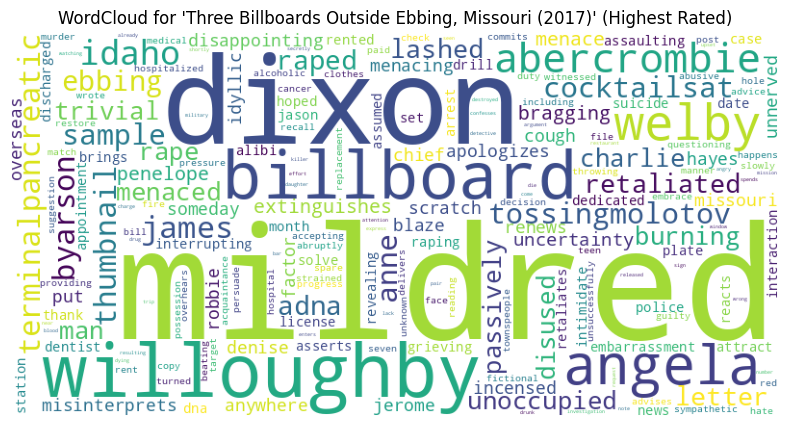

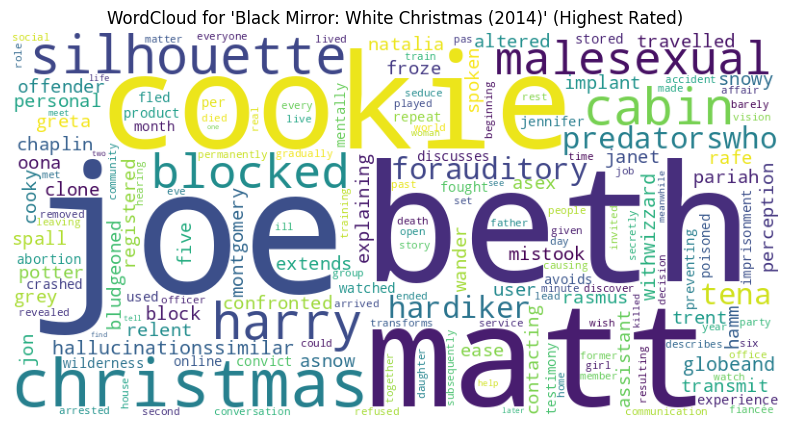

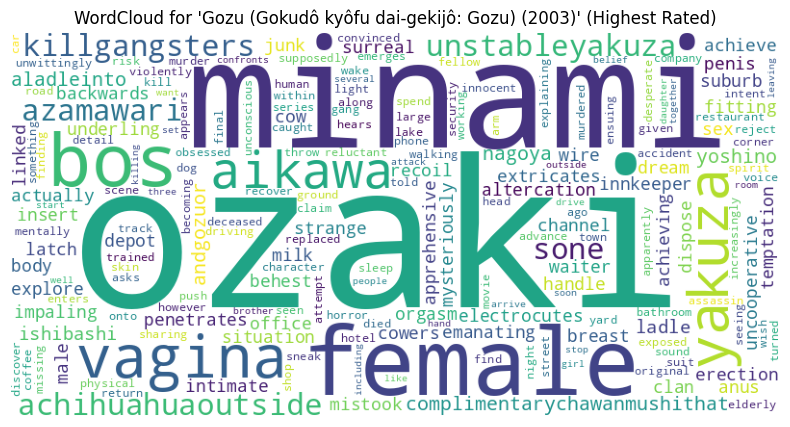

In [189]:
for id, tf_idf in top_3_highest_tfidf.items():
    word_freq = dict(tf_idf)  
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"WordCloud for '{get_movie_title_from_id(id)}' (Highest Rated)")
    plt.show()

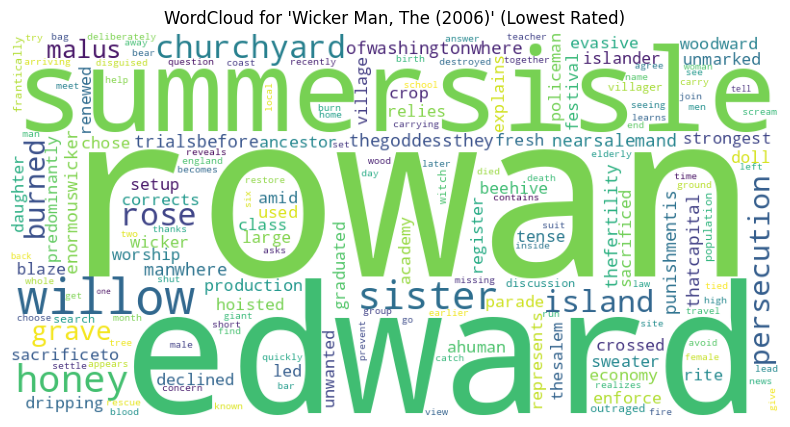

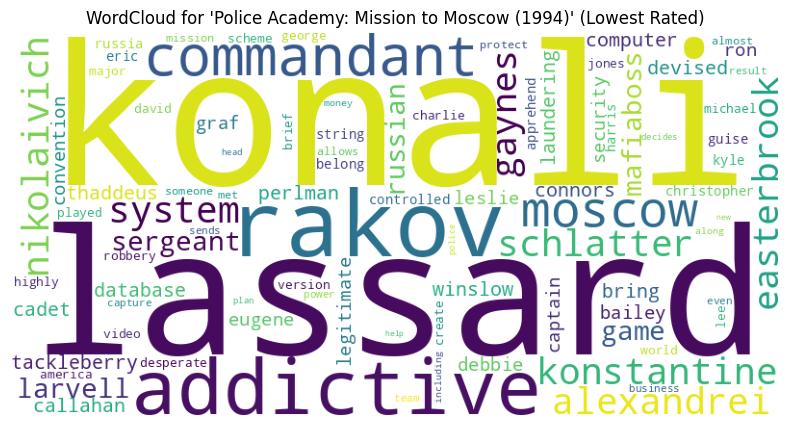

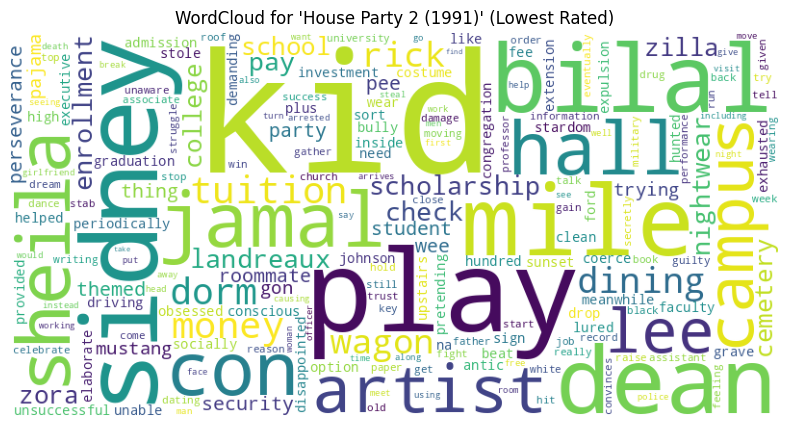

In [163]:
for id, tf_idf in top_3_lowest_tfidf.items():
    word_freq = dict(tf_idf)  
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"WordCloud for '{get_movie_title_from_id(id)}' (Lowest Rated)")
    plt.show()

### Genre based

In [164]:
movie_id_genre_dict = defaultdict(list)

for user_id, genres in user_genre_movies.items():
    for genre, movies in genres.items():
        for movie_id, (title, rating) in movies.items():
            movie_id_genre_dict[movie_id].append(genre)

In [165]:
def get_genre_to_all_texts_in_one(movie_id_plot_tokens, movie_id_genre_dict):
    genre_to_all_texts_in_one = {}
    total_movies = len(movie_id_genre_dict)
    
    for count, (movie_id, genres) in enumerate(movie_id_genre_dict.items(), 1):
        if count % 10 == 0:
            print(f"get_genre_to_all_texts_in_one {count} / {total_movies}")
        
        movie_plot_tokens = movie_id_plot_tokens.get(movie_id, [])
        
        for genre in genres:
            if genre not in genre_to_all_texts_in_one:
                genre_to_all_texts_in_one[genre] = []
            
            if movie_plot_tokens: 
                genre_to_all_texts_in_one[genre].append(movie_plot_tokens)
    
    for genre, texts in genre_to_all_texts_in_one.items():
        genre_to_all_texts_in_one[genre] = [item for sublist in texts for item in sublist]
    
    return genre_to_all_texts_in_one


In [166]:
def get_movie_id_plot_tokens(movie_id_plot):
    movie_id_plot_tokens = {}
    total = len(movie_id_plot)
    count = 1
    for movie_id, plot in movie_id_plot.items():
        tokens = get_tokens_for_tfidf(plot)
        movie_id_plot_tokens[movie_id] = tokens
        if count % 10 == 0:
            print(f"get_movie_id_plot_tokens {count} / {total}")
        count += 1
    return movie_id_plot_tokens

In [167]:
def get_genre_tf_dict(genre_to_tokens):
    genre_tf_dict = {}
    for genre, tokens in genre_to_tokens.items():
        tf_dict = {}
        for token in tokens:
            if token not in tf_dict:
                tf_dict[token] = 1
            else:
                tf_dict[token] += 1
        tf_dict = dict(sorted(tf_dict.items(), key=lambda x: x[1], reverse=True))
        genre_tf_dict[genre] = tf_dict
    return genre_tf_dict

In [168]:
def get_idf_dict(genre_tf_dict):
    word_document_count = defaultdict(int)
    total_documents = len(genre_tf_dict)

    for tokens in genre_tf_dict.values():
        for token in tokens:
            word_document_count[token] += 1

    idf_dict = {}
    for word, count in word_document_count.items():
        idf_dict[word] = math.log(total_documents / count)
    return idf_dict

In [169]:
def get_tf_idf_dict(genre_tf_dict, idf_dict):
    genre_tf_idf_dict = {}
    for genre, tf_dict in genre_tf_dict.items():
        tf_idf_dict = {}
        for token, count in tf_dict.items():
            tf_idf_dict[token] = count * idf_dict[token]
        genre_tf_idf_dict[genre] = dict(sorted(tf_idf_dict.items(), key=lambda x: x[1], reverse=True))
    return genre_tf_idf_dict

In [170]:
name = "genre_tfidf_dict"
if not os.path.exists(f"{os.path.join(base_path, f'{name}.pbz2')}"):
    movie_id_plot_tokens = get_movie_id_plot_tokens(movie_id_plot)
    genre_to_all_texts_in_one = get_genre_to_all_texts_in_one(movie_id_plot_tokens, movie_id_genre_dict)
    genre_tf_dict = get_genre_tf_dict(genre_to_all_texts_in_one)
    idf_dict = get_idf_dict(genre_tf_dict)
    genre_tfidf = get_tf_idf_dict(genre_tf_dict, idf_dict)
    save(name, genre_tfidf)

genre_tfidf = load(name)

In [171]:
genre_stats_sorted = {genre: genre_stats[genre] for genre in sorted(genre_stats, key=lambda x: genre_stats[x]['mean'], reverse=True)}
genre_tfidf_sorted = {genre: genre_tfidf[genre] for genre in genre_stats_sorted}

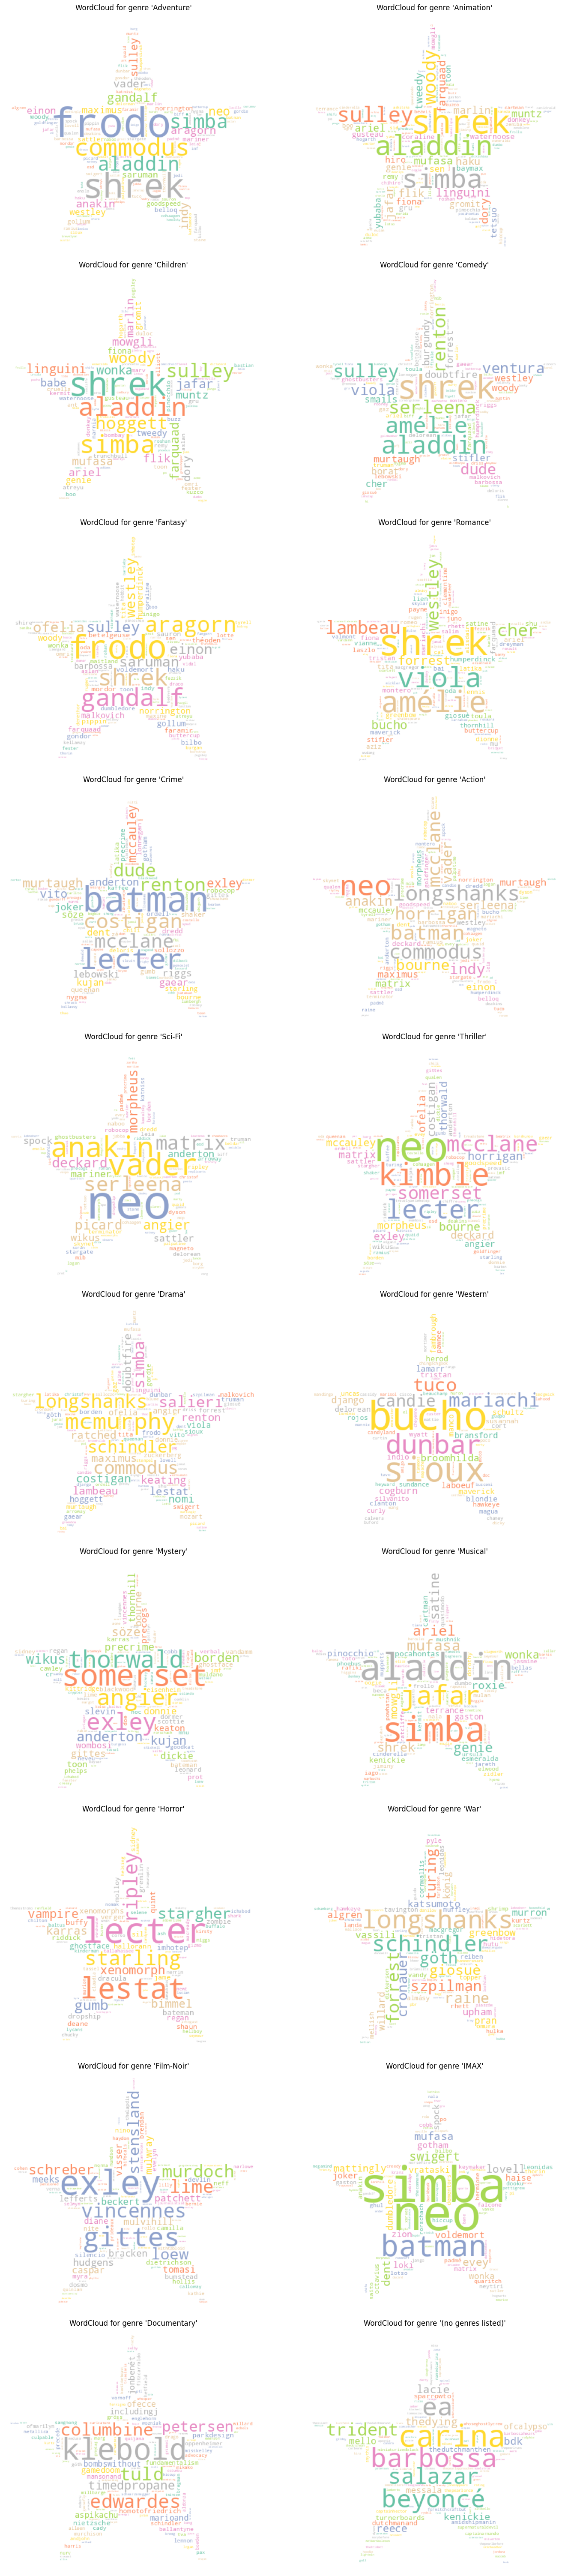

In [179]:
mask = np.array(Image.open('../images/star.png'))

num_genres = len(genre_tfidf)
num_rows = (num_genres + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(14, 6 * num_rows), constrained_layout=True)
axes = axes.flatten()

for idx, (genre, tf_idf) in enumerate(genre_tfidf.items()):
    word_freq = dict(tf_idf)
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False, colormap='Set2', mask=mask).generate_from_frequencies(word_freq)
    
    ax = axes[idx]
    ax.imshow(wordcloud)
    ax.axis('off')
    ax.set_title(f"WordCloud for genre '{genre}'")

for i in range(len(genre_tfidf), len(axes)):
    fig.delaxes(axes[i])

plt.show()